## Data sources

In order to validate the claims from [this](https://www.bloomberg.com/news/articles/2020-05-11/why-chicken-is-plentiful-during-the-pandemic-and-beef-is-not?srnd=premium&utm_medium=social&utm_source=twitter&utm_campaign=socialflow-organic&utm_content=markets&cmpid%3D=socialflow-twitter-markets&sref=XQtHDW1P) article, I downloaded price data from [FRED](https://fred.stlouisfed.org) and adjusted it using the CPI. Data sources are here:

- [Poultry](https://fred.stlouisfed.org/series/APU0000706111)
- [Pork](https://fred.stlouisfed.org/series/APU0000FD3101)
- [Beef](https://fred.stlouisfed.org/series/APU0000703112)

The chart below shows how the average price of 3 different types of meats has changed over time.

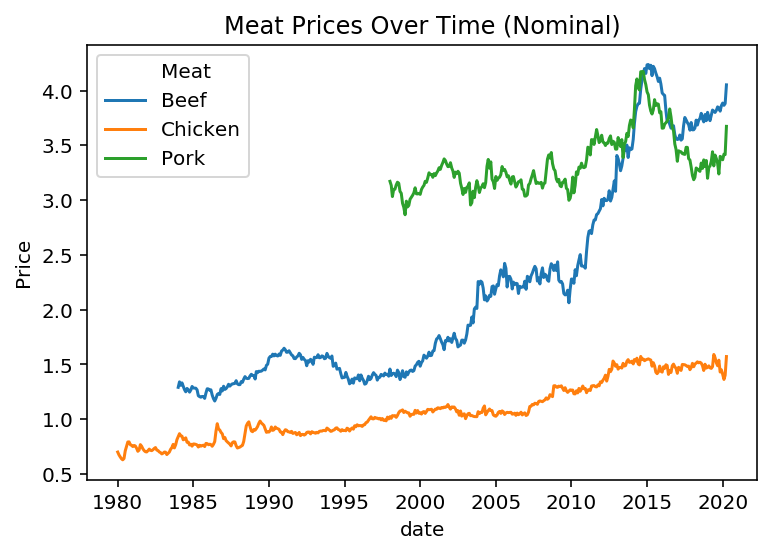

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from IPython.core.display import HTML

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# https://github.com/jupyter/notebook/issues/3670
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%run ./helpers.ipynb

cpi = get_cpi()
pcs = get_prices()

sns.lineplot(x='date', y='price', hue='Meat', data=pcs);
plt.title('Meat Prices Over Time (Nominal)')
plt.ylabel('Price');

To adjust for the change in purchasing power I'll use the CPI.

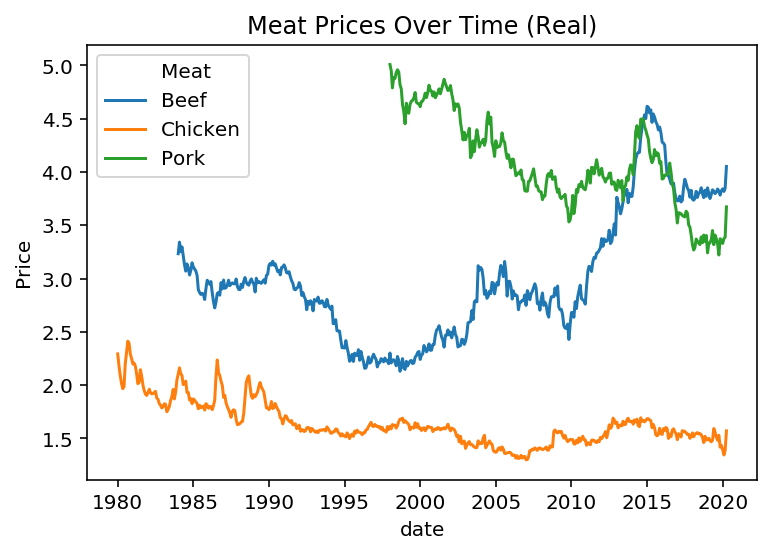

In [2]:
CURRENT_CPI = cpi.loc[cpi.date == cpi.date.max(), 'cpi'].values[0]

adjust = (
    pcs.merge(cpi, how='left', on=['date'])
    .assign(cur_price = lambda x: get_adjust(past_cpi=x.cpi,
                                             current_cpi = CURRENT_CPI,
                                             past_price = x.price))
    
);
adjust.pipe(lambda x: 
            sns.lineplot(x='date', y='cur_price', hue='Meat', data=x))

plt.ylabel('Price')
plt.title('Meat Prices Over Time (Real)');

In [3]:
his = {
    'Beef':.63,
    'Chicken':-.62,
    'Pork':-.12
}
x = (
    adjust.groupby('Meat').apply(lambda x: get_diff(x, 'cur_price', 'date'))
    .reset_index()
    .drop(labels='level_1', axis=1)
    .assign(NumYears = lambda x: x['End'].dt.year - x['Start'].dt.year)
    .assign(av = lambda x: x.Change / x.NumYears)
    .assign(Extrap = lambda x: x.Change / x.NumYears * 85)
    .assign(his = lambda x: x['Meat'].map(his))
)

A couple things to note about the real prices:

- Pork has declined in 26.2% from 1998
- Beef has increased 25% from 1984
- Chicken has decreased 31.4% since 1980

In order to adjust for the different number of years between myself and the author, I'll convert the growth rate into a yearly one and extrapolate backwards. This requires the assumption that the growth rates between all the meats are constant.

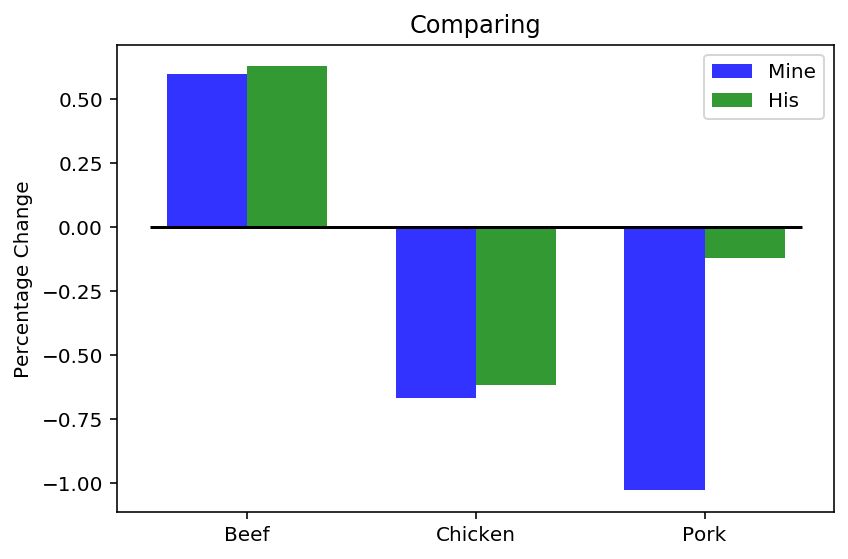

In [4]:
n_groups = 3

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, 
                 x['Extrap'], 
                 bar_width,
                 alpha=opacity,
                 color='b',
                 label='Mine')

rects2 = plt.bar(index + bar_width,
                 x['his'], 
                 bar_width,
                 alpha=opacity,
                 color='g',
                 label='His')

plt.hlines(y=0, xmin=-.25, xmax=2.6)
plt.ylabel('Percentage Change')
plt.title('Comparing')
plt.xticks(index + bar_width / 2, ('Beef', 'Chicken', 'Pork'))
plt.legend()

plt.tight_layout()
plt.show()

I finally arrive at the above numbers. My estimates for beef and chicken are both very similar.